In [241]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

In [242]:
var = 0.1
a = 0
b = 1
K = 2
N = 50

In [243]:
def phi(X, K):
    N = len(X)
    V = np.zeros((N, K))
    for i in range(K):
        V[:,i] = X**i
    return V

In [244]:
def ell(theta, K, X, Y):
    return 0.5 * (np.linalg.norm(phi(X, K)@theta - Y)**2)

def grad_ell(theta, K, X, Y):
    return phi(X, K).T @ (((phi(X, K))@theta) - Y)

In [245]:
def ell_map(lam):
    return lambda theta, K, X, Y: 0.5 * ((np.linalg.norm(phi(X, K)@theta - Y)**2) + (lam/2) * np.linalg.norm(theta)**2)

def grad_ell_map(lam):
    return lambda theta, K, X, Y: phi(X, K).T @ ((phi(X, K) @ theta) - Y) + 2 * lam * theta

In [246]:
def x_split(X, Y, N_train):
    N = len(X)

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[test_idx]
    Ytest = Y[test_idx]

    return Xtrain, Xtest, Ytrain, Ytest

In [247]:
def theta_calc_eq(phi_X, Y):
    first_fact = phi_X.T @ phi_X
    second_fact = phi_X.T @ Y
    try:
        L = scipy.linalg.choleksy(first_fact, lower = True)
        y = scipy.linalg.solve_triangular(L, b, lower = True)
        theta_found_normeq = scipy.linalg.solve_triangular(L.T, y)
    except:
        theta_found_normeq = np.linalg.solve(first_fact, second_fact)
    return theta_found_normeq

In [248]:
def theta_calc_eq_map(phi_X, Y, lam, K):
    first_fact = np.linalg.inv(phi_X.T @ phi_X + (lam * np.eye(K)))
    second_fact = phi_X.T @ Y
    return first_fact @ second_fact

In [249]:
def GD(t0, D, K, tolf=1e-6, tolx=1e-6, kmax=1000, alpha=1e-2, f=ell, grad_f=grad_ell):
    (X, Y) = D

    tk = t0
    f_vals = [f(tk, K, X, Y)]
    grad_vals = [grad_f(tk, K, X, Y)]
    err_vals = [np.linalg.norm(grad_f(tk, K, X, Y))]
    t_vals = [tk]
    iteration = 0

    while iteration < kmax:
        t_prec = tk

        tk = t_prec - (alpha*grad_f(t_prec, K, X, Y))

        t_vals.append(tk)
        f_vals.append(f(tk, K, X, Y))
        grad_vals.append(grad_f(tk, K, X, Y))       
        err_vals.append(np.linalg.norm(grad_f(tk, K, X, Y)))

        iteration+=1

        if np.linalg.norm(grad_f(tk, K, X, Y)) < tolf:
            break

        if np.linalg.norm(tk - t_prec, 2) < tolx:
            break

    return tk

In [250]:
def SGD(t0, D, K, batch_size = 5, n_epochs = 10, alpha=1e-5, l=ell, grad_l=grad_ell):
    (X, Y) = D
    N = len(X)
    
    X_backup = X
    Y_backup = Y


    n_batch_per_epoch = N // batch_size
    t_vals = [t0]
    f_vals = [l(t0, K, X, Y)]
    grad_f_vals = [grad_l(t0, K, X, Y)]
    err_vals = [np.linalg.norm(grad_l(t0, K, X, Y))]

    for epoch in range(n_epochs):
        idx = np.arange(N)
        np.random.shuffle(idx)

        for k in range(n_batch_per_epoch):
            batch_indices = idx[k * batch_size : (k + 1) * batch_size]

            Mx = X[batch_indices]
            My = Y[batch_indices]

            t = t_vals[-1] - alpha * grad_l(t_vals[-1], K, Mx, My)
            t_vals.append(t)

        
        X = X_backup
        Y = Y_backup
        f_vals.append(l(t, K, X, Y))
        grad_f_vals.append(grad_l(t, K, X, Y))
        err_vals.append(np.linalg.norm(grad_l(t, K, X, Y)))

    return t_vals[-1]
    

In [251]:
def create_set(K=K, N=N, a=a, b=b):    
    X = np.linspace(a, b, N)
    theta_true = np.ones((K,))

    e = np.random.normal(0, var, N)

    Y = phi(X, K) @ theta_true + e

    N_train = int(N/3*2)
    X_train, X_test, Y_train, Y_test = x_split(X, Y, N_train)

    return X_train, X_test, Y_train, Y_test

In [252]:
X_train, X_test, Y_train, Y_test = create_set()
D = (X_train, Y_train)

In [253]:
def MLE(K, theta_calc, D):

    (X, Y) = D
    theta_found = None

    if theta_calc == "NE":
        theta_found = theta_calc_eq(phi(X, K), Y)
    elif theta_calc == "GD":
        theta_zero_1 = np.zeros((K,))
        theta_found = GD(theta_zero_1, D, K)
    elif theta_calc == "SGD":
        theta_zero_1 = np.random.normal(1, var, K)
        theta_found = SGD(theta_zero_1, D, K)

    return theta_found
    

In [254]:
def MAP(K, theta_calc, D, lam = 1):

    (X, Y) = D
    theta_found = None

    if theta_calc == "NE":
        theta_found = theta_calc_eq_map(phi(X, K), Y, lam, K)
    elif theta_calc == "GD":
        theta_zero_1 = np.zeros((K,))
        theta_found = GD(theta_zero_1, D, K, f=ell_map(lam), grad_f=grad_ell_map(lam))
    elif theta_calc == "SGD":
        theta_zero_1 = np.random.normal(1, var, K)
        theta_found = SGD(theta_zero_1, D, K, l=ell_map(lam), grad_l = grad_ell_map(lam))

    return theta_found
    

In [255]:
k0 = 2
k1 = 4
k2 = 15
k3 = 30
k4 = 45

theta_neq_0 = MLE(k0, "NE", D)
theta_neq_1 = MLE(k1, "NE", D)
theta_neq_2 = MLE(k2, "NE", D)
theta_neq_3 = MLE(k3, "NE", D)
theta_neq_4 = MLE(k4, "NE", D)

In [256]:
def fixed_f(X, K, theta_found):
    return phi(X, K)@theta_found 

def avg_abs_err(theta_found, K, set):
    X, Y = set
    return ((np.linalg.norm(fixed_f(X, K, theta_found) - Y)**2) / len(X))

In [257]:
train_set = (X_train, Y_train)

test_set = (X_test, Y_test)

print("Average absolute error for K=" + str(k1) + ": " + str(avg_abs_err(theta_neq_1, k1, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k2) + ": " + str(avg_abs_err(theta_neq_2, k2, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k3) + ": " + str(avg_abs_err(theta_neq_3, k3, train_set)) + " on train set.")

print("Average absolute error for K=" + str(k1) + ": " + str(avg_abs_err(theta_neq_1, k1, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k2) + ": " + str(avg_abs_err(theta_neq_2, k2, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k3) + ": " + str(avg_abs_err(theta_neq_3, k3, test_set)) + " on test set.")

Average absolute error for K=4: 0.006175519624461148 on train set.
Average absolute error for K=15: 0.004958028646409998 on train set.
Average absolute error for K=30: 0.004009422448739697 on train set.
Average absolute error for K=4: 0.01781429826747595 on test set.
Average absolute error for K=15: 0.6226106542474003 on test set.
Average absolute error for K=30: 4.3750252692706075 on test set.


In [258]:
def plot_for_K(theta, K, method, a=a, b=b, var=var, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test):
    fig, ax = plt.subplots(1, figsize = (10, 8))

    x_to_plot = np.linspace(a, b, 1000)
    y_to_plot = fixed_f(x_to_plot, K, theta)
    ax.plot(x_to_plot, y_to_plot, label="learnt model")

    ax.scatter(X_train, Y_train, label="train dps")
    ax.scatter(X_test, Y_test, label="test dps")


 
    plt.title("Regression model for K="+str(K)+" with " + method)
    plt.legend(loc="upper left")
    plt.show()

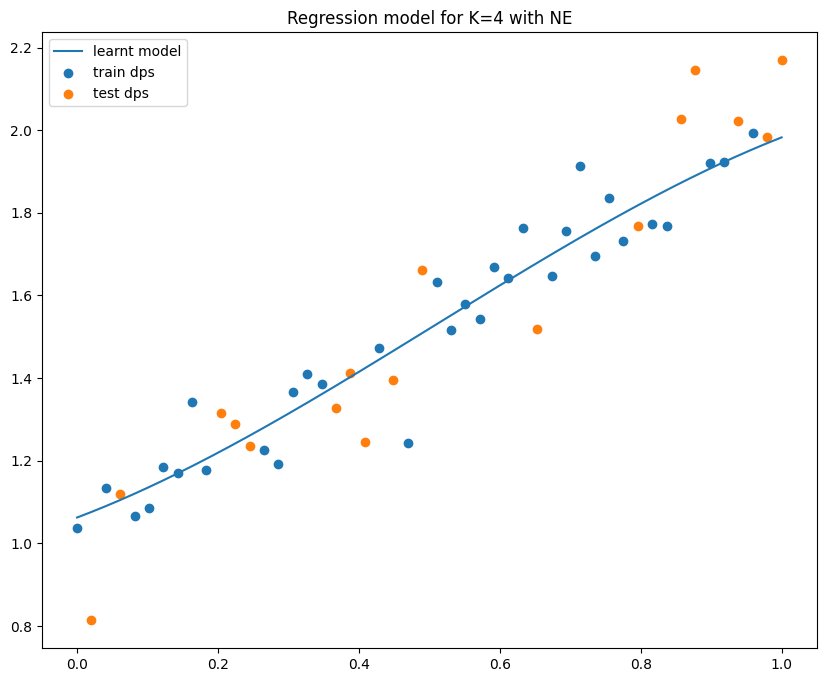

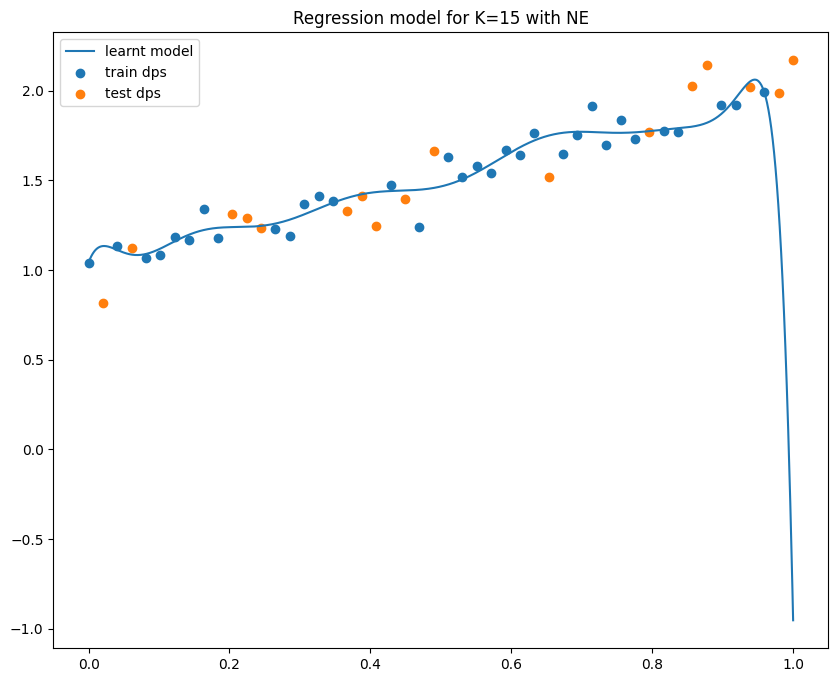

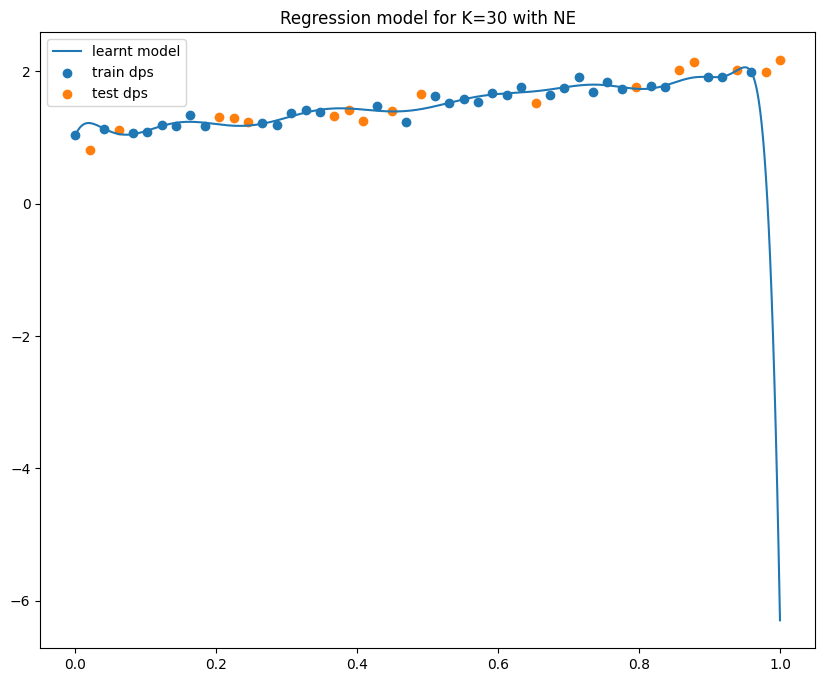

In [259]:
plot_for_K(theta_neq_1, k1, "NE")
plot_for_K(theta_neq_2, k2, "NE")
plot_for_K(theta_neq_3, k3, "NE")

In [260]:
k1_gd = 2
k2_gd = 4
k3_gd = 8

theta_gd_1= MLE(k1_gd, "GD", D)
theta_gd_2= MLE(k2_gd, "GD", D)
theta_gd_3= MLE(k3_gd, "GD", D)

In [261]:
print("Average absolute error for K=" + str(k1_gd) + ": " + str(avg_abs_err(theta_gd_1, k1_gd, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k2_gd) + ": " + str(avg_abs_err(theta_gd_2, k2_gd, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k3_gd) + ": " + str(avg_abs_err(theta_gd_3, k3_gd, train_set)) + " on train set.")

print("Average absolute error for K=" + str(k1_gd) + ": " + str(avg_abs_err(theta_gd_1, k1_gd, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k2_gd) + ": " + str(avg_abs_err(theta_gd_2, k2_gd, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k3_gd) + ": " + str(avg_abs_err(theta_gd_3, k3_gd, test_set)) + " on test set.")

Average absolute error for K=2: 0.0062684458332272685 on train set.
Average absolute error for K=4: 0.006248467317158911 on train set.
Average absolute error for K=8: 0.006225034617022242 on train set.
Average absolute error for K=2: 0.0165009440047935 on test set.
Average absolute error for K=4: 0.01631272013365398 on test set.
Average absolute error for K=8: 0.018315110373812015 on test set.


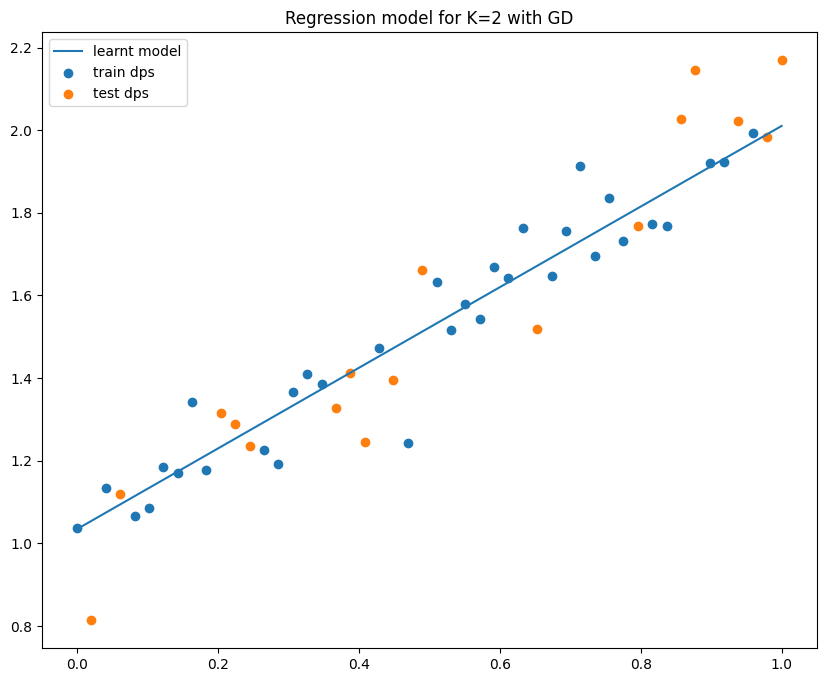

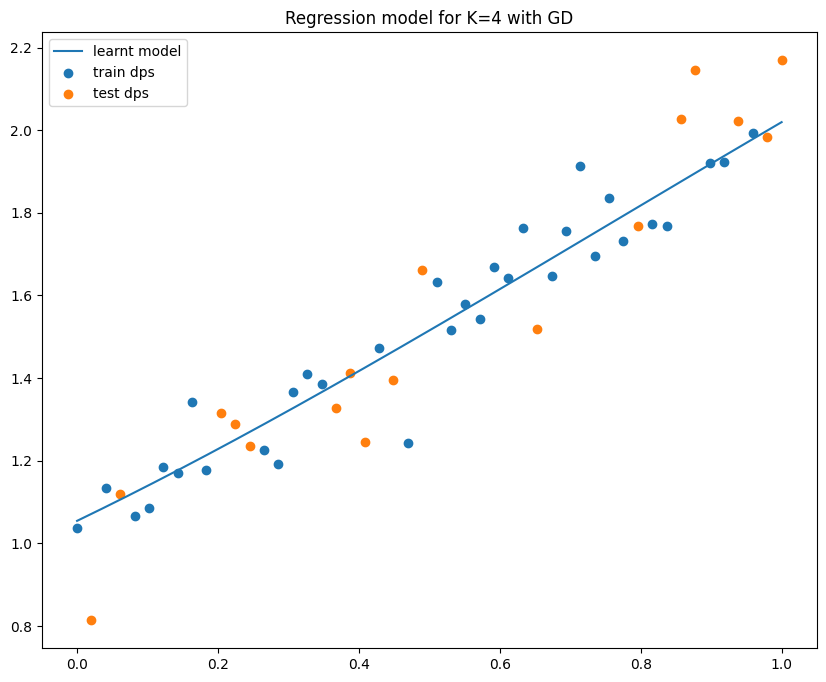

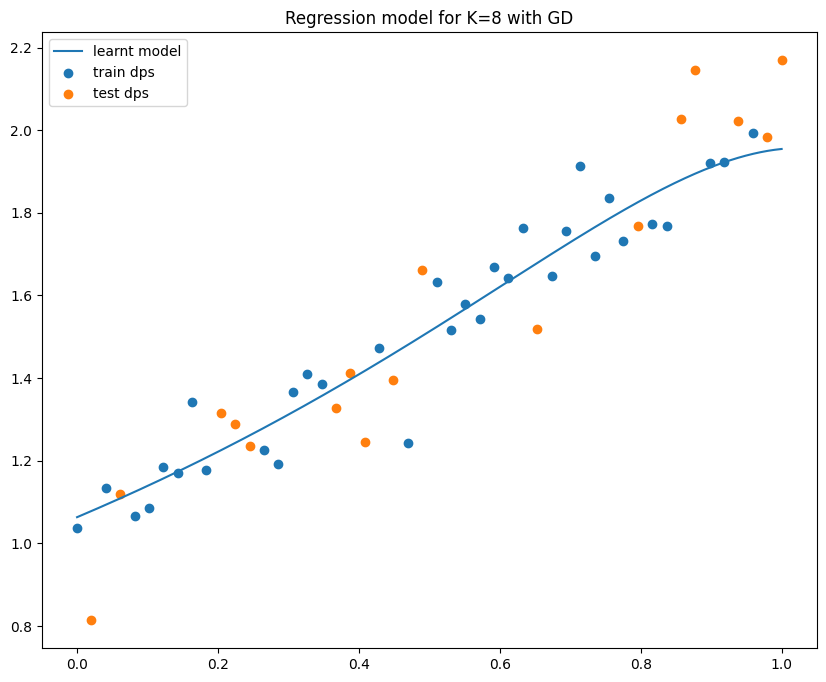

In [262]:
plot_for_K(theta_gd_1, k1_gd, "GD")
plot_for_K(theta_gd_2, k2_gd, "GD")
plot_for_K(theta_gd_3, k3_gd, "GD")

In [263]:
k1_sgd = 2
k2_sgd = 4
k3_sgd = 8

theta_sgd_1= MLE(k1_sgd, "SGD", D)
theta_sgd_2= MLE(k2_sgd, "SGD", D)
theta_sgd_3= MLE(k3_sgd, "SGD", D)

In [264]:
print("Average absolute error for K=" + str(k1_sgd) + ": " + str(avg_abs_err(theta_sgd_1, k1_sgd, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k2_sgd) + ": " + str(avg_abs_err(theta_sgd_2, k2_sgd, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k3_sgd) + ": " + str(avg_abs_err(theta_sgd_3, k3_sgd, train_set)) + " on train set.")

print("Average absolute error for K=" + str(k1_sgd) + ": " + str(avg_abs_err(theta_sgd_1, k1_sgd, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k2_sgd) + ": " + str(avg_abs_err(theta_sgd_2, k2_sgd, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k3_sgd) + ": " + str(avg_abs_err(theta_sgd_3, k3_sgd, test_set)) + " on test set.")

Average absolute error for K=2: 0.008770569660989274 on train set.
Average absolute error for K=4: 0.3044468359464126 on train set.
Average absolute error for K=8: 2.473370234753496 on train set.
Average absolute error for K=2: 0.021567678164073692 on test set.
Average absolute error for K=4: 0.5010277822421455 on test set.
Average absolute error for K=8: 5.7472489014886925 on test set.


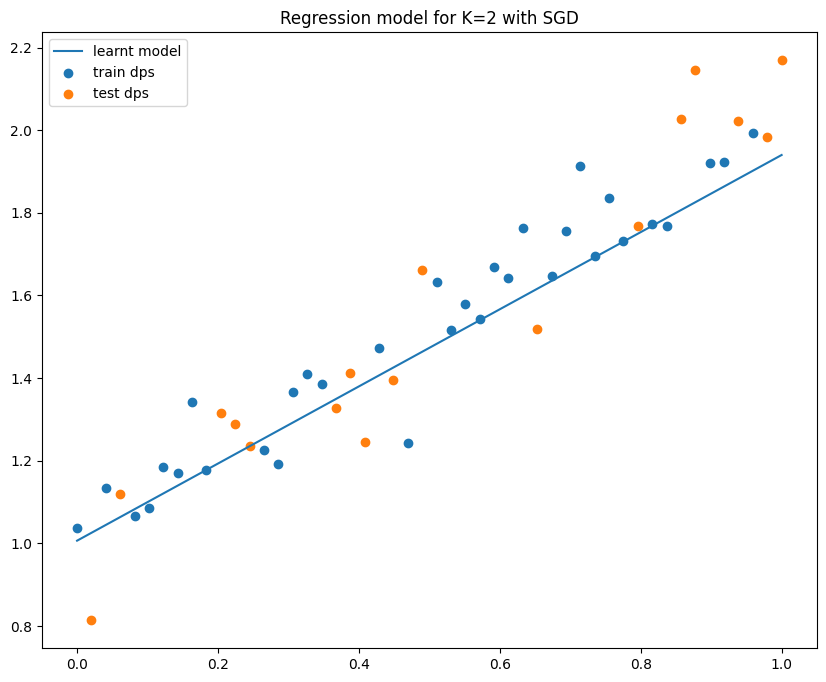

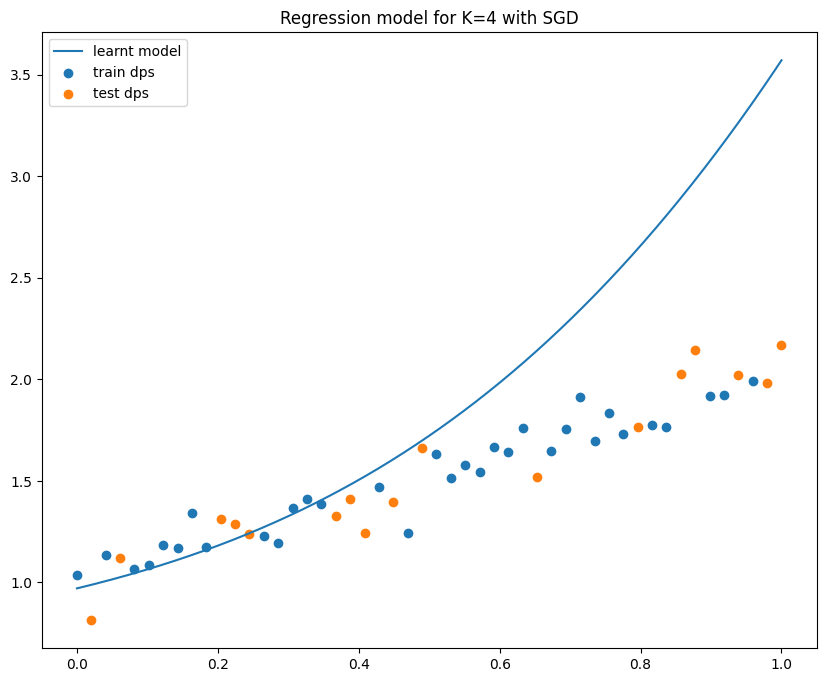

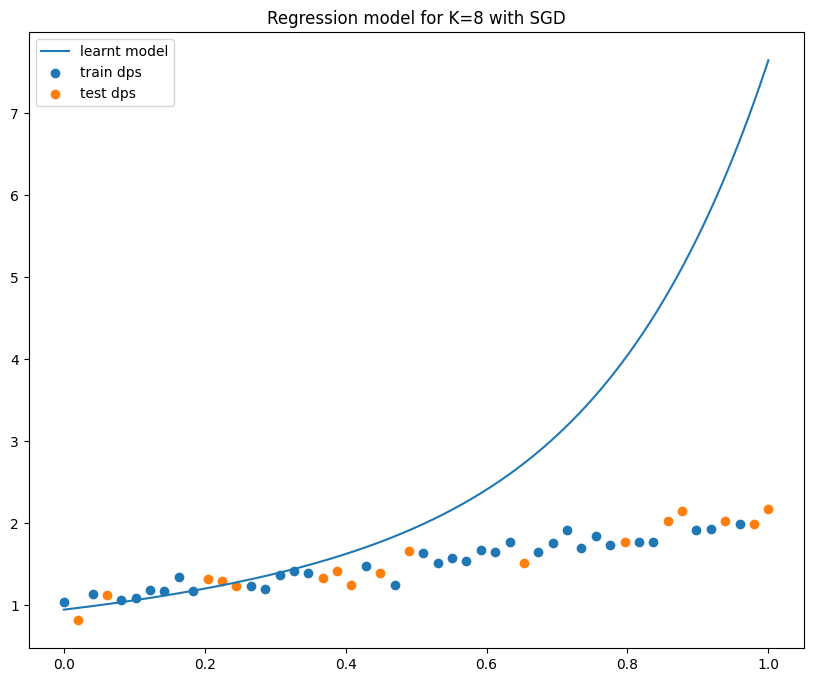

In [265]:
plot_for_K(theta_sgd_1, k1_sgd, "SGD")
plot_for_K(theta_sgd_2, k2_sgd, "SGD")
plot_for_K(theta_sgd_3, k3_sgd, "SGD")

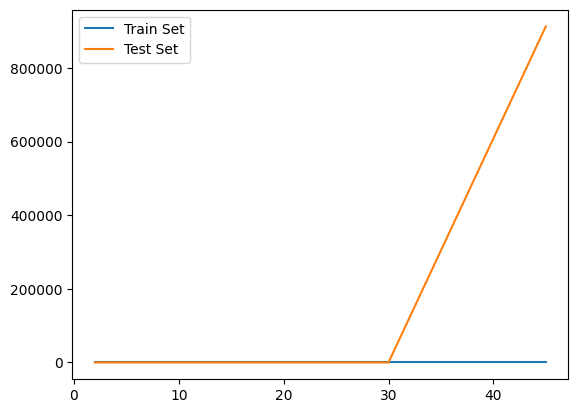

In [266]:
ks_0 = [k0, k1, k2, k3, k4]

err_0_0 = avg_abs_err(theta_neq_0, k0, train_set)
err_0_1 = avg_abs_err(theta_neq_1, k1, train_set)
err_0_2 = avg_abs_err(theta_neq_2, k2, train_set)
err_0_3 = avg_abs_err(theta_neq_3, k3, train_set)
err_0_4 = avg_abs_err(theta_neq_4, k4, train_set)
errs_0 = [err_0_0, err_0_1, err_0_2, err_0_3, err_0_4]

err_1_0 = avg_abs_err(theta_neq_0, k0, test_set)
err_1_1 = avg_abs_err(theta_neq_1, k1, test_set)
err_1_2 = avg_abs_err(theta_neq_2, k2, test_set)
err_1_3 = avg_abs_err(theta_neq_3, k3, test_set)
err_1_4 = avg_abs_err(theta_neq_4, k4, test_set)

errs_1 = [err_1_0, err_1_1, err_1_2, err_1_3, err_1_4]

plt.plot(ks_0, errs_0, label="Train Set")
plt.plot(ks_0, errs_1, label="Test Set")
plt.legend(loc="upper left")
plt.show()

In [267]:
k1 = 2
k2 = 5
k3 = 10
ks = [k1, k2, k3]
lams = [1, 3, 5]

theta_neq_1_M = MAP(k1, "NE", D, lam=lams[0])
theta_neq_2_M = MAP(k2, "NE", D, lam=lams[0])
theta_neq_3_M = MAP(k3, "NE", D, lam=lams[0])

thetas_1_M = [theta_neq_1_M, theta_neq_2_M, theta_neq_3_M]

theta_gd_4_M = MAP(k1, "NE", D, lam=lams[1])
theta_gd_5_M = MAP(k2, "NE", D, lam=lams[1])
theta_gd_6_M = MAP(k3, "NE", D, lam=lams[1])

thetas_2_M = [theta_gd_4_M, theta_gd_5_M, theta_gd_6_M]

theta_sgd_7_M = MAP(k1, "NE", D, lam=lams[2])
theta_sgd_8_M = MAP(k2, "NE", D, lam=lams[2])
theta_sgd_9_M = MAP(k3, "NE", D, lam=lams[2])

thetas_3_M = [theta_sgd_7_M, theta_sgd_8_M, theta_sgd_9_M]

In [268]:
print("Average absolute error for K=" + str(k1) + ": " + str(avg_abs_err(theta_neq_1_M, k1, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k2) + ": " + str(avg_abs_err(theta_neq_2_M, k2, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k3) + ": " + str(avg_abs_err(theta_neq_3_M, k3, train_set)) + " on train set.")

print("Average absolute error for K=" + str(k1) + ": " + str(avg_abs_err(theta_neq_1_M, k1, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k2) + ": " + str(avg_abs_err(theta_neq_2_M, k2, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k3) + ": " + str(avg_abs_err(theta_neq_3_M, k3, test_set)) + " on test set.")

Average absolute error for K=2: 0.008589969032947176 on train set.
Average absolute error for K=5: 0.00881519247603349 on train set.
Average absolute error for K=10: 0.00853670045186656 on train set.
Average absolute error for K=2: 0.025042342260517853 on test set.
Average absolute error for K=5: 0.015538949963536915 on test set.
Average absolute error for K=10: 0.015828270339987398 on test set.


In [269]:
def plot_for_K_lam(thetas, Ks, lam, method, a=a, b=b, var=var, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test):
    
    fig, ax = plt.subplots(1,len(Ks), figsize = (20, 5))
    plt.suptitle("Lambda = " + str(lam) + " with " + method)
    for i, K in enumerate(Ks):
        x_to_plot = np.linspace(a, b, 2000)
        y_to_plot = fixed_f(x_to_plot, K, thetas[i])
        ax[i].plot(x_to_plot, y_to_plot, label="learnt model")

        ax[i].scatter(X_train, Y_train, label="train dps")
        ax[i].scatter(X_test, Y_test, label="test dps")


    
        ax[i].set_title("K="+str(K))
        ax[i].legend(loc="upper left")
    plt.show()


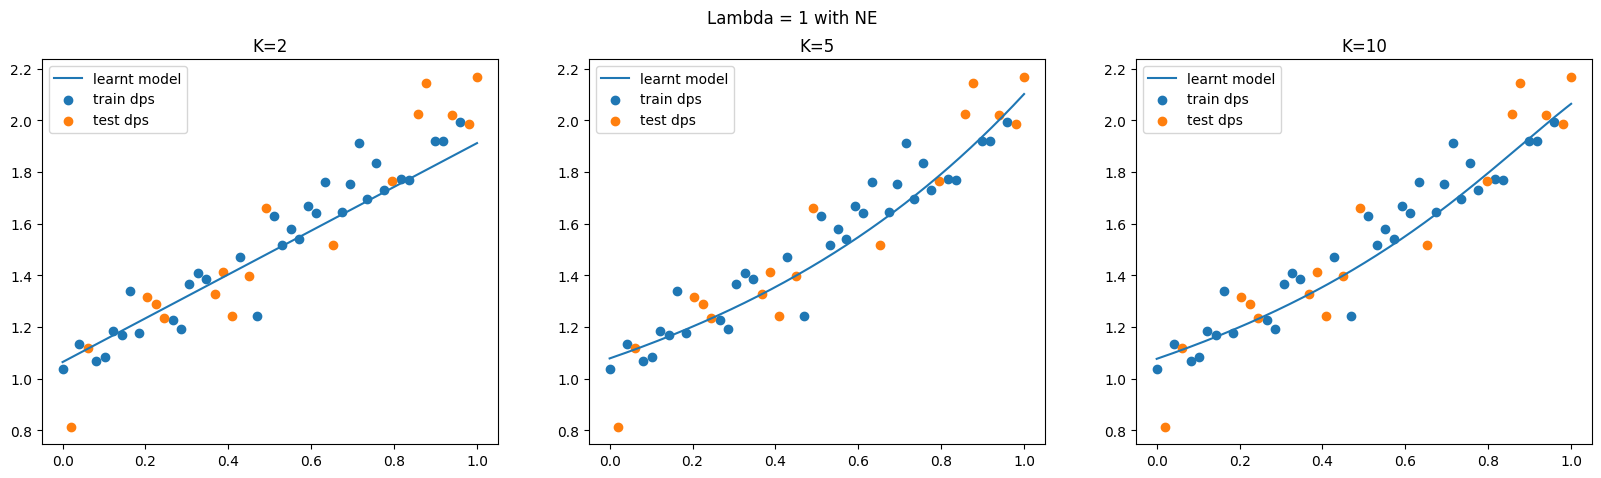

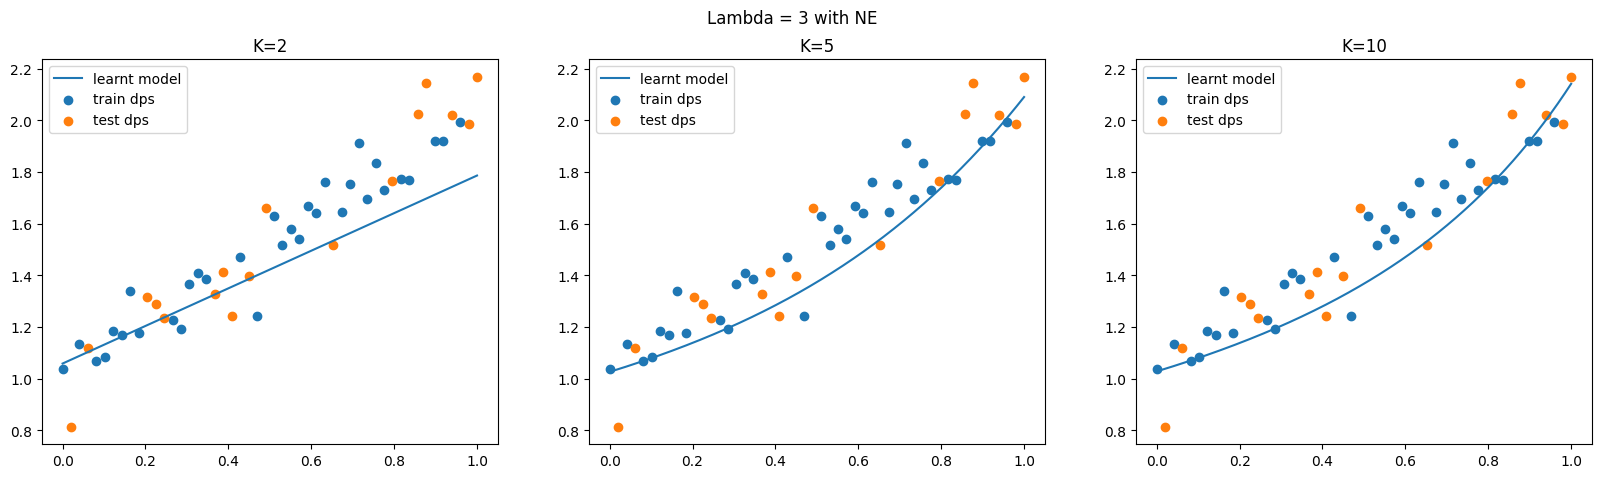

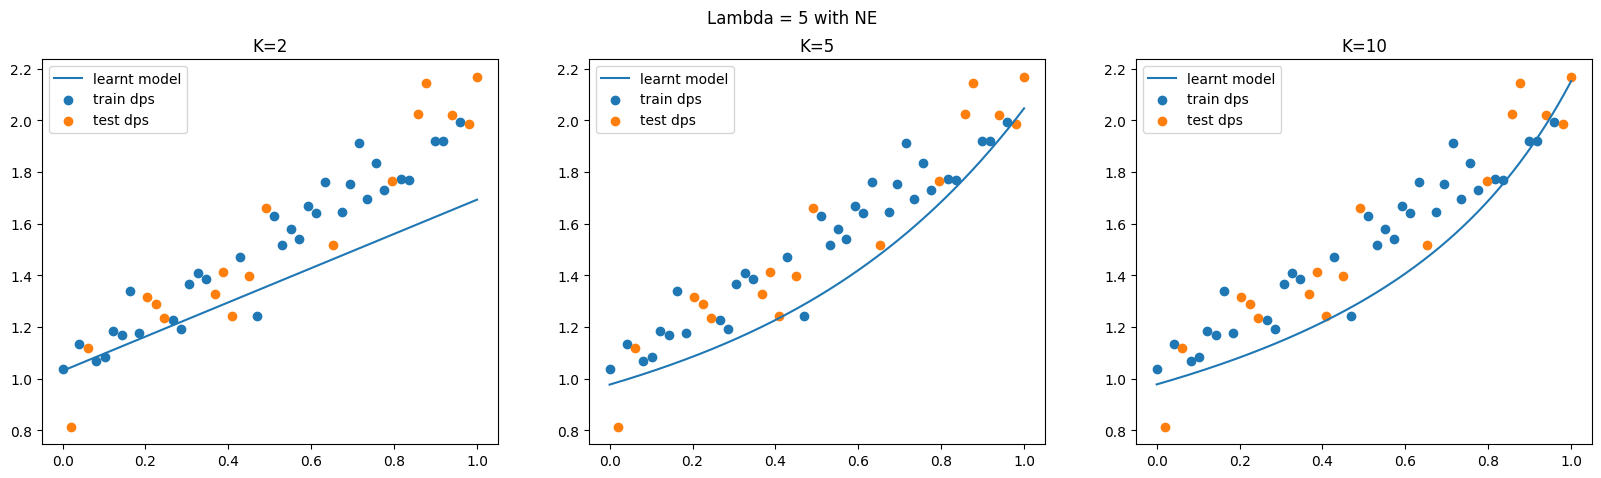

In [270]:
plot_for_K_lam(thetas_1_M, ks, lams[0], "NE")
plot_for_K_lam(thetas_2_M, ks, lams[1], "NE")
plot_for_K_lam(thetas_3_M, ks, lams[2], "NE")

In [322]:
def err(theta):
    t_len = len(theta)
    theta_true = np.concatenate((np.ones((K,)), np.zeros((t_len-K,))))
    return ((np.linalg.norm(theta - theta_true))/(np.linalg.norm(theta_true)))

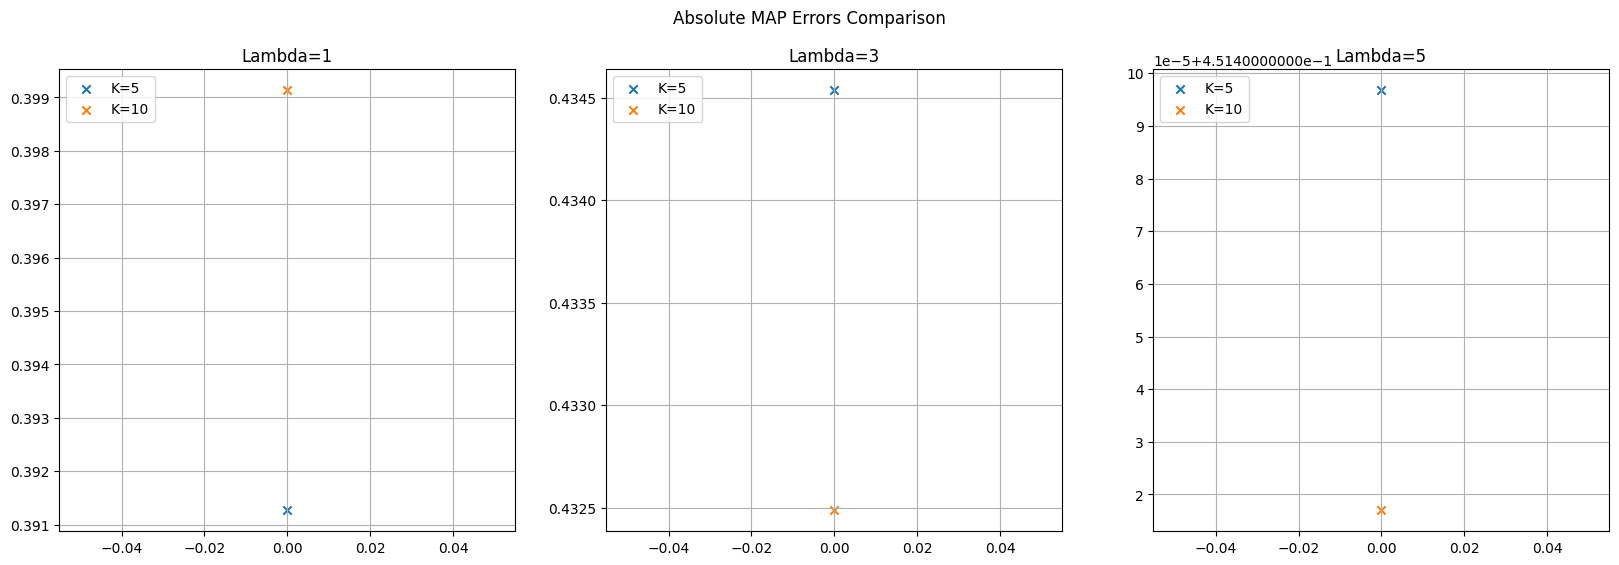

In [323]:
thetas_neq_MLE = [theta_neq_2, theta_neq_3, theta_neq_4]
k_neq_MLE = [k2, k3, k4]
thetas_gd_MLE = [theta_gd_2, theta_gd_3]
k_gd_MLE = [k2_gd, k3_gd]
thetas_sgd_MLE = [theta_sgd_2, theta_sgd_3]
k_sgd_MLE = [k2_sgd, k3_sgd]

errs_neq_MLE = [err(theta) for theta in thetas_neq_MLE]
errs_gd_MLE = [err(theta) for theta in thetas_gd_MLE]
errs_sgd_MLE = [err(theta) for theta in thetas_sgd_MLE]

errs_1_MAP = [err(theta) for theta in thetas_1_M[1:]]
errs_2_MAP = [err(theta) for theta in thetas_2_M[1:]]
errs_3_MAP = [err(theta) for theta in thetas_3_M[1:]]

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 6))
for item in zip(errs_1_MAP, ks[1:]):
    ax0.scatter(0, item[0], label="K="+str(item[1]), marker='x')
    ax0.grid(visible=True)
    ax0.legend(loc="upper left")
    ax0.set_title("Lambda="+str(lams[0]))
for item in zip(errs_2_MAP, ks[1:]):
    ax1.scatter(0, item[0], label="K="+str(item[1]), marker='x')
    ax1.grid(visible=True)
    ax1.legend(loc="upper left")
    ax1.set_title("Lambda="+str(lams[1]))
for item in zip(errs_3_MAP, ks[1:]):
    ax2.scatter(0, item[0], label="K="+str(item[1]), marker='x')
    ax2.grid(visible=True)
    ax2.legend(loc="upper left")
    ax2.set_title("Lambda="+str(lams[2]))
fig.suptitle("Absolute MAP Errors Comparison")

plt.show()

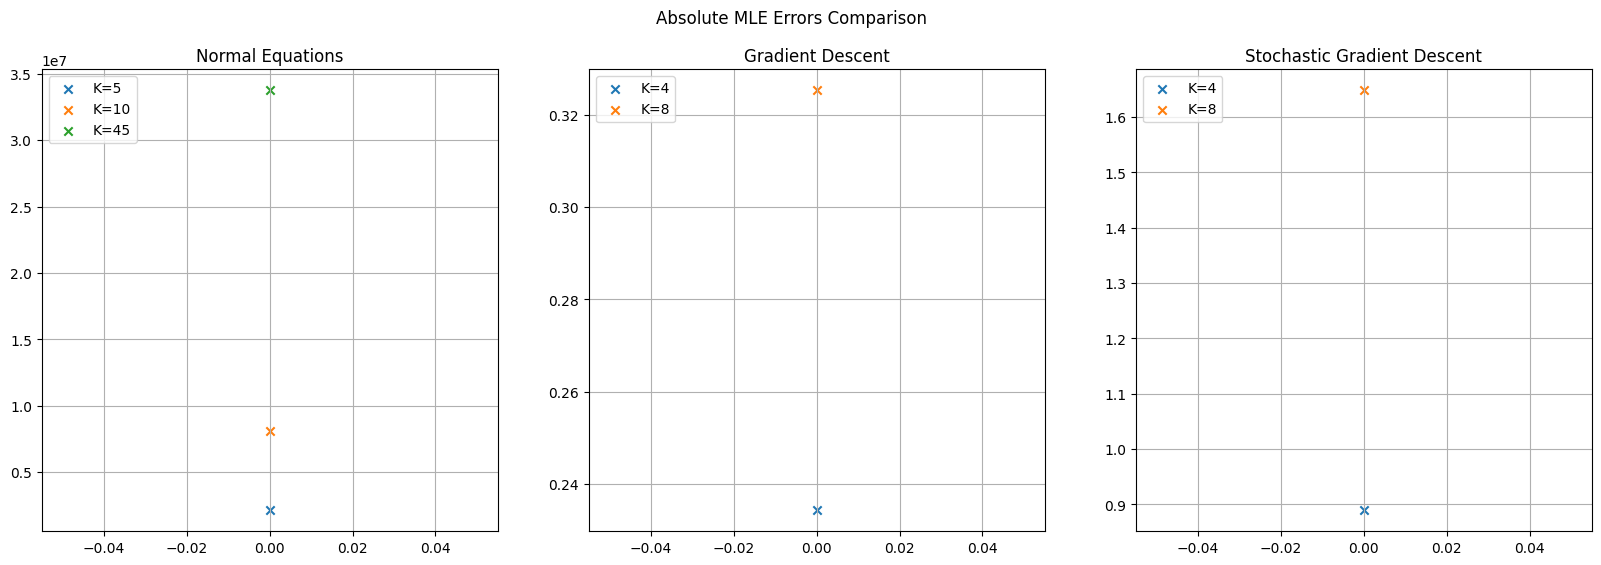

In [324]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 6))
for item in zip(errs_neq_MLE, k_neq_MLE):
    ax0.scatter(0, item[0], label="K="+str(item[1]), marker='x')
    ax0.grid(visible=True)
    ax0.legend(loc="upper left")
    ax0.set_title("Normal Equations")
for item in zip(errs_gd_MLE, k_gd_MLE):
    ax1.scatter(0, item[0], label="K="+str(item[1]), marker='x')
    ax1.grid(visible=True)
    ax1.legend(loc="upper left")
    ax1.set_title("Gradient Descent")
for item in zip(errs_sgd_MLE, k_gd_MLE):
    ax2.scatter(0, item[0], label="K="+str(item[1]), marker='x')
    ax2.grid(visible=True)
    ax2.legend(loc="upper left")
    ax2.set_title("Stochastic Gradient Descent")
fig.suptitle("Absolute MLE Errors Comparison")

plt.show()